# Import functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


from sklearn.feature_selection import mutual_info_regression

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.append('../../nn_physical_concepts')

from scinet import *
import scinet.ed_oscillator as edo

# Load data

In [2]:
import pandas as pd

df = pd.read_csv('../../transient_data_ch41step.csv')


In [248]:
df_rates = pd.read_csv('../../constant_data_ch41step.csv')


In [276]:
kf = np.zeros((1,1001))
for i in range(1001):
    kf[0,i] = float(df_rates['kf'][i][1:-1])

In [279]:
kf = kf[0]

# Helper functions

In [370]:
def my_load_traindata(df,thalf = 1.25e-5):
    mydf = df[df['t [s]'] <=thalf]
    in1 = np.zeros((2001*25,25))
    in2 = np.zeros((2001*25,1))
    out = np.zeros((2001*25,1))
    for j in range(25):
        for i in range(1000,3001):
            in1[(i-1000)*25 + j,:] = mydf[mydf['T [K]']==i]['Yco2']
    in2[:,0] = mydf['t [s]']
    out[:,0] = mydf['Yco2']
    return [in1, in2, out]

def my_load_traindata_3(df,thalf = 1.25e-5):
    mydf = df[df['t [s]'] <=thalf]
    in1 = np.zeros((2001*25,25))
    in2 = np.zeros((2001*25,3))
    out = np.zeros((2001*25,1))
    for j in range(25):
        for i in range(1000,3001):
            in1[(i-1000)*25 + j,:] = mydf[mydf['T [K]']==i]['Yco2']
    in2[:,0] = mydf['t [s]']
    in2[:,1] = mydf['Yo2']
    in2[:,2] = mydf['Ych4']
    out[:,0] = mydf['Yco2']
    return [in1, in2, out]

def my_load_testdata(df,T,thalf = 1.25e-5 ):
    mydf = df[df['t [s]'] <= thalf]
    in1 = np.zeros((51,25))
    in2 = np.zeros((51,1))
    for i in range(51): 
        in1[i,:] = mydf[mydf['T [K]']==T]['Yco2']
        in2[i,0] = i*5e-7
    out = in2
    return [in1,in2,out]

def my_load_testdata3(df,T,thalf = 1.25e-5 ):
    mydf = df[df['t [s]'] <= thalf]
    in1 = np.zeros((51,25))
    in2 = np.zeros((51,3))
    for i in range(51): 
        in1[i,:] = mydf[mydf['T [K]']==T]['Yco2']
        in2[i,0] = i*5e-7
    in2[:,1] = df[df['T [K]']==T]['Yo2']
    in2[:,2] = df[df['T [K]']==T]['Ych4']
    out = np.zeros((51,1))
    return [in1,in2,out]

def my_load_testdata_singletime(df,T,time,thalf = 1.25e-5 ):
    mydf = df[df['t [s]'] <= thalf]
    in1 = np.zeros((1,25))
    in2 = np.zeros((1,3))
    in1[0,:] = mydf[mydf['T [K]']==T]['Yco2']
    in2[0,0] = time
    in2[:,1] = df[(df['T [K]']==T) & (df['t [s]']<(time+4e-7))& (df['t [s]']>(time-4e-7))]['Yo2']
    in2[:,2] = df[(df['T [K]']==T) & (df['t [s]']<(time+4e-7))& (df['t [s]']>(time-4e-7))]['Ych4']
    out = np.zeros((1,1))
    return [in1,in2,out]

from sklearn.model_selection import train_test_split

def my_train_test_split(train_data3,test_size = 0.25,random_state=42):
    in1train, in1test = train_test_split(train_data3[0], test_size=test_size, random_state=random_state)
    in2train, in2test = train_test_split(train_data3[1], test_size=test_size, random_state=random_state)
    outtrain, outtest = train_test_split(train_data3[2], test_size=test_size, random_state=random_state)
    return [in1train,in2train,outtrain],[in1test,in2test,outtest]



# Train and predict

In [374]:
train_data3  = my_load_traindata_3(df,thalf = 1.25e-5)

In [375]:
train_data, valid_data  = my_train_test_split(train_data3)

In [376]:
net = nn.Network(latent_size = 3,input_size =  25,input2_size = 3,output_size = 1,encoder_num_units= [500, 100],)
net.train(training_data = train_data, validation_data = valid_data,epoch_num = 100, batch_size =  128, learning_rate = 1e-3,test_step=None)

  0%|          | 0/100 [00:00<?, ?it/s]

In [377]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times'],'size' : 16})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

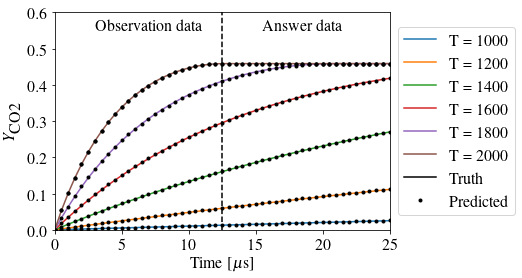

In [378]:
t = np.arange(51)*5e-1 #mus
T = 1000
plt.plot([12.5,12.5],[0,0.6],'k--')
for T in range(1000,2001,200): 
    test_data = my_load_testdata3(df,T)
    a_precicted = net.run(test_data, net.output).ravel()
    plt.plot(t,a_precicted,label = r'T = '+str(T))

    plt.plot(t,df[df['T [K]']==T]['Yco2'],'k.',label='_nolegend_')

plt.plot([-1],[-1],'k',label ='Truth')

plt.plot(t,df[df['T [K]']==T]['Yco2'],'k.',label='Predicted')

plt.legend(loc='center right',bbox_to_anchor = (1.4,0.5))
plt.xlim((0,25))
plt.ylim((0,0.6))
plt.text(3,0.55,'Observation data')
plt.text(15.5,0.55,'Answer data')
plt.ylabel(r'$Y_{\textrm{CO2}}$')
plt.xlabel(r'Time [$\mu$s]')
plt.savefig('chem_prediction.png',dpi=400,bbox_inches='tight')

In [379]:
latentspace = np.zeros((101,3))
time = 1.5e-5
for T in range(1000,3001,30):
    latentspace[(T-1000)/30,:] = np.array([net.run(my_load_testdata_singletime(df,T,time), net.mu)[0] ])

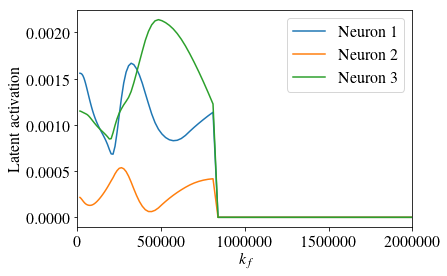

In [380]:
plt.plot(kf[0:1001:10],latentspace[:,0],label = 'Neuron 1')
plt.plot(kf[0:1001:10],latentspace[:,1],label ='Neuron 2')
plt.plot(kf[0:1001:10],latentspace[:,2],label = 'Neuron 3')
plt.ylabel('Latent activation')
plt.legend()
plt.xlabel(r'$k_f$')
plt.xlim([0,2e6])
plt.xticks([0,5e5,1e6,1.5e6,2e6])
plt.savefig('chem_latent.png',dpi=400,bbox_inches='tight')

### Helper functions for plots

In [8]:
def osc_eqn(A_0, delta_0, b, kappa, t):
    return np.real(A_0 * np.exp(-b / 2. * t) * np.exp(1 / 2. * np.sqrt(b**2 - 4 * kappa + 0.j) * t + 1.j * delta_0))

def gen_input(A_0, delta_0, b, kappa, tt_predicted):
    tt_in = np.linspace(0, 5, 50)
    in1 = np.array([osc_eqn(A_0, delta_0, b, kappa, tt_in) for _ in tt_predicted])
    in2 = np.reshape(tt_predicted, (-1, 1))
    out = in2 #dummy filler
    return [in1, in2, out]

In [9]:
tmp = gen_input(1, 0, 0.5, 5.,  np.linspace(0, 10, 250))
# plt.plot(np.linspace(0, 10, 50),tmp[0][:,0])
# plt.plot(np.linspace(0, 5, 50),tmp[0][2])

In [12]:
tmp[1].shape

(250, 1)

In [172]:
train_data3[1]

array([[ 0.00000000e+00,  6.66666667e-01,  3.33333333e-01],
       [ 5.00000000e-07,  6.65898093e-01,  3.33140669e-01],
       [ 1.00000000e-06,  6.65130406e-01,  3.32948227e-01],
       ...,
       [ 1.10000000e-05, -1.63118607e-14,  1.66214983e-01],
       [ 1.15000000e-05, -1.63118607e-14,  1.66214983e-01],
       [ 1.20000000e-05, -1.63118607e-14,  1.66214983e-01]])

In [3]:
blue_color='#000cff'
orange_color='#ff7700'

In [4]:
def pendulum_prediction(net, b, kappa):    
    tt_given = np.linspace(0, 10, 250)
    tt_predicted = np.linspace(0, 10, 250)
    a_given = osc_eqn(1, 0, b, kappa, tt_given)
    a_precicted = net.run(gen_input(1, 0, b, kappa, tt_predicted), net.output).ravel()
    fig = plt.figure(figsize=(3.4, 2.1))
    ax = fig.add_subplot(111)
    ax.plot(tt_given, a_given, color=orange_color, label='True time evolution')
    ax.plot(tt_predicted, a_precicted, '--', color=blue_color, label='Predicted time evolution')
    ax.set_xlabel(r'$t$ [$s$]')
    ax.set_ylabel(r'$x$ [$m$]')
    handles, labels = ax.get_legend_handles_labels()
    lgd=ax.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.6, 1.3), shadow=True, ncol=1)
    fig.tight_layout()
    return fig

In [5]:
def osc_representation_plot(net, b_range, kappa_range, step_num=100, eval_time=7.5):
    bb = np.linspace(*b_range, num=step_num)
    kk = np.linspace(*kappa_range, num=step_num)
    B, K = np.meshgrid(bb, kk)
    out = np.array([net.run(gen_input(1, 0, b, kappa, [eval_time]), net.mu)[0] for b, kappa in zip(np.ravel(B), np.ravel(K))])
    fig = plt.figure(figsize=(net.latent_size*3.9, 2.1))
    for i in range(net.latent_size):
        zs = out[:, i]
        ax = fig.add_subplot('1{}{}'.format(net.latent_size, i + 1), projection='3d')
        Z = np.reshape(zs, B.shape)
        surf = ax.plot_surface(B, K, Z, rstride=1, cstride=1, cmap=cm.inferno, linewidth=0)
        ax.set_xlabel(r'$b$ [$kg/s$]')
        ax.set_ylabel(r'$\kappa$ [$kg/s^2$]')
        ax.set_zlabel('Latent activation {}'.format(i + 1))
        if (i==2):
            ax.set_zlim(-1,1) #Fix the scale for the third plot, where the activation is close to zero
        ax.set_zticks([-1,-0.5,0,0.5,1])
    fig.tight_layout()
    return fig

## Load pre-trained model

### Parameters
- `latent_size: 2` 
- `input_size: 50`
- `input2_size: 1`
- `output_size: 1`
- `encoder_num_units: [500, 100]`
- other parameters: default values
### Data
- Only kappa and b are varied (in the default intervals), A_0 and delta_0 are fixed
- `t_sample: np.linspace(0, 5, 50)` (fed into the network)
- `t_meas_interval: (0, 10)` (time interval in which prediction times lie)
- training data: 95000 samples
- validation data: 5000 samples

### Training
- `epoch_num: 1000`, `batch_size: 512`, `learning_rate: 1e-3`, `beta: 1e-3`

In [6]:
net_2_latent = nn.Network.from_saved('oscillator')

{'decoder_num_units': [100, 100], 'input2_size': 1, 'tot_epochs': 1000, 'latent_size': 2, 'output_size': 1, 'encoder_num_units': [500, 100], 'input_size': 50, 'load_file': 'oscillator', 'name': 'oscin2_5'}







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








INFO:tensorflow:Restoring parameters from /Users/wtchung/Documents/CS230/nn_physical_concepts/tf_save/oscillator.ckpt
Loaded network from file oscillator


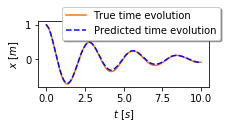

In [7]:
pendulum_prediction(net_2_latent, 0.5, 5.);

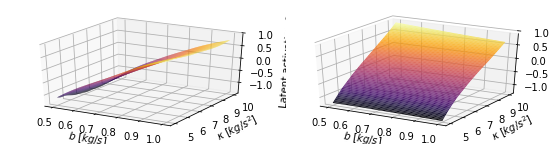

In [8]:

osc_representation_plot(net_2_latent, [0.5, 1], [5, 10]);

## Load pre-trained model

### Parameters
- `latent_size: 3` 
- Rest as for `net_2_latent`

In [11]:
net_3_latent = nn.Network.from_saved('oscillator_3_latent')

{'decoder_num_units': [100, 100], 'input2_size': 1, 'tot_epochs': 1000, 'latent_size': 3, 'output_size': 1, 'encoder_num_units': [500, 100], 'input_size': 50, 'load_file': 'oscillator_3_latent', 'name': 'osc_3_latent'}
INFO:tensorflow:Restoring parameters from /Users/wtchung/Documents/CS230/nn_physical_concepts/tf_save/oscillator_3_latent.ckpt
Loaded network from file oscillator_3_latent


In [12]:
pendulum_prediction(net_3_latent, 0.5, 5.);

In [13]:
osc_representation_plot(net_3_latent, [0.5, 1], [5, 10]);

## Calculate L2 norm of error

In [14]:
data, states, params = edo.oscillator_data(50000, t_meas_interval=(0, 10))

In [15]:
np.sqrt(net_3_latent.run(data, net_3_latent.recon_loss))

0.013979528

## Calculate mutual information between latent neurons

In [16]:
data, states, params = edo.oscillator_data(200000, t_meas_interval=(0, 10))

In [17]:
# Calculate the mutual information between two latent neurons
def mi(net, data, latent_neuron_1, latent_neuron_2):
    mu = net_3_latent.run(data, net_3_latent.mu)
    mi_estimate = mutual_info_regression(mu[:,latent_neuron_1].reshape(-1, 1), mu[:,latent_neuron_2], discrete_features = False)
    return mi_estimate[0]

In [18]:
mi(net_3_latent, data, 0, 0)

10.949938727096288

In [19]:
mi(net_3_latent, data, 0, 1)

0.10576364483239242

In [23]:
np.array(data)

ValueError: could not broadcast input array from shape (200000,50) into shape (200000)